Output sizes: 
(266, 400, 3)
(348, 348, 3)


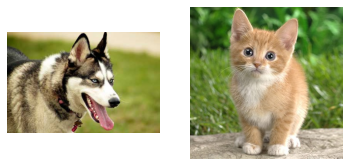

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):

    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].shape)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(Image.fromarray(images[i]))
    plt.show()

images = [
    np.array(Image.open('../assets/dog.jpg')),
    np.array(Image.open('../assets/cat.jpg'))
]
show_images(images)

In [2]:
import urllib.request
import json

def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")
labels = load_labels('imagenet-simple-labels.json')

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

def predict(image, raw_result):
    res = postprocess(raw_result)    

    idx = np.argmax(res)

    print('========================================')
    print('Final top prediction is: ' + labels[idx])
    print('========================================')

    sort_idx = np.flip(np.squeeze(np.argsort(res)))
    print('============ Top 5 labels are: ============================')
    print(labels[sort_idx[:5]])
    print('===========================================================')

    plt.axis('off')
    display_image = plt.imshow(image)

In [3]:
import onnx
import onnxruntime

hub_model = onnx.hub.load_composite_model(
    'ResNet50-fp32', 'ResNet-preproc', 
    preproc_repo='jantonguirao/models:resnet_preproc')
onnx.save(hub_model, 'resnet50-e2e.onnx')

session = onnxruntime.InferenceSession('resnet50-e2e.onnx', providers=["CPUExecutionProvider"])
raw_result = session.run([], {'images': images})[0]
print(f"Raw result: dtype={raw_result.dtype} shape={raw_result.shape}")

Using cached ResNet-preproc model from /home/janton/.cache/onnx/hub/vision/classification/resnet/preproc/9cda24af90b4cd2ced4167fa36a41956ea0ce5e55c6ae475614a097cb89762c7_resnet-preproc-v1-18.onnx
Using cached ResNet50-fp32 model from /home/janton/.cache/onnx/hub/vision/classification/resnet/model/3f03fdef724b22947eed826f1eef1dc5c34151bb4c37d634f1db89dfa2dd1526_resnet50-v1-12.onnx
Raw result: dtype=float32 shape=(2, 1000)


2023-03-09 21:14:30.698895621 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x9f90140__0x9f3a850_axes_input'. It is not used by any node and should be removed from the model.
2023-03-09 21:14:30.698921790 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x9f90140__0x9f3a850_k2'. It is not used by any node and should be removed from the model.


Final top prediction is: husky
============ Top 5 labels are: ============================
['husky' 'Siberian Husky' 'Alaskan Malamute' 'Norwegian Elkhound'
 'grey wolf']


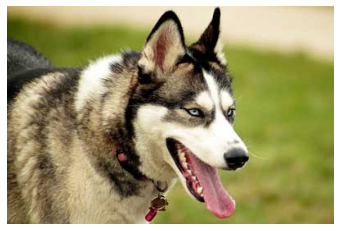

In [4]:
predict(images[0], raw_result[0])

Final top prediction is: kit fox
============ Top 5 labels are: ============================
['kit fox' 'tiger cat' 'tabby cat' 'lynx' 'red fox']


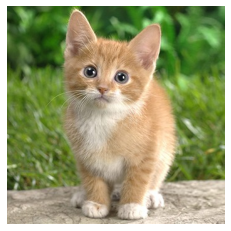

In [5]:
predict(images[1], raw_result[1])